## 今天相对于昨天的增长率

数据集总长度: 1308
所有日期范围: 2021-01-01 00:00:00 到 2024-07-31 00:00:00
训练集截止日期: 2023-11-13 00:00:00
split_date是否在数据范围内: True

划分后:
训练集大小: 1046
测试集大小: 262
测试数据形状: (262, 26)


/tmp/ipykernel_11516/1171340685.py:100: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  X_train = torch.FloatTensor(train_sequences)


Epoch [5/300], Loss: 0.0005
Epoch [10/300], Loss: 0.0008
Epoch [15/300], Loss: 0.0027
Epoch [20/300], Loss: 0.0008
Epoch [25/300], Loss: 0.0007
Epoch [30/300], Loss: 0.0007
Epoch [35/300], Loss: 0.0006
Epoch [40/300], Loss: 0.0009
Epoch [45/300], Loss: 0.0020
Epoch [50/300], Loss: 0.0007
Epoch [55/300], Loss: 0.0010
Epoch [60/300], Loss: 0.0008
Epoch [65/300], Loss: 0.0007
Epoch [70/300], Loss: 0.0008
Epoch [75/300], Loss: 0.0005
Epoch [80/300], Loss: 0.0005
Epoch [85/300], Loss: 0.0004
Epoch [90/300], Loss: 0.0003
Epoch [95/300], Loss: 0.0013
Epoch [100/300], Loss: 0.0004
Epoch [105/300], Loss: 0.0002
Epoch [110/300], Loss: 0.0006
Epoch [115/300], Loss: 0.0005
Epoch [120/300], Loss: 0.0006
Epoch [125/300], Loss: 0.0003
Epoch [130/300], Loss: 0.0006
Epoch [135/300], Loss: 0.0003
Epoch [140/300], Loss: 0.0011
Epoch [145/300], Loss: 0.0006
Epoch [150/300], Loss: 0.0007
Epoch [155/300], Loss: 0.0004
Epoch [160/300], Loss: 0.0002
Epoch [165/300], Loss: 0.0002
Epoch [170/300], Loss: 0.0001


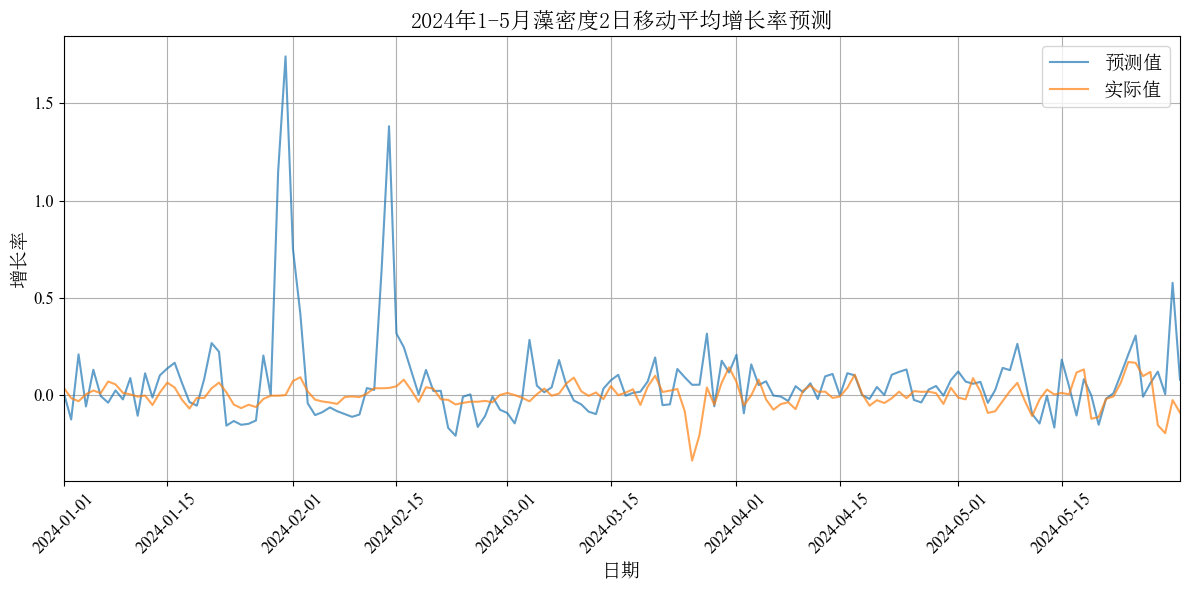

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import logging
from torch.optim.lr_scheduler import OneCycleLR

# 设置字体
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimSun', 'DejaVu Sans']
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['axes.unicode_minus'] = False

chinese_font = fm.FontProperties(fname='/root/Download/Modis-algae-aliyun/AlgaeBloomForecast-20241122/SIMSUN.TTC', size=14)
english_font = fm.FontProperties(fname='/root/Download/Modis-algae-aliyun/AlgaeBloomForecast-20241122/TIMES.TTF', size=14)

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
# 读取数据
df = pd.read_csv('20-merged_all_data.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# 今天相对于昨天的增长率
df['density_growth'] = (df['density'].shift(-1) - df['density']) / df['density']
df['density_growth'] = df['density_growth'].interpolate(method='linear')
window_size = 2
df['density_growth_smoothed'] = df['density_growth'].rolling(window=window_size, center=True).mean()
df['density_growth_smoothed'] = df['density_growth_smoothed'].interpolate(method='linear')

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                           batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

def create_sequence_for_date(data, date_index, seq_length):
    """为指定日期创建输入序列"""
    if date_index < seq_length:
        return None
    return data[date_index - seq_length:date_index]

# 数据预处理
features = ['temperature', 'pH', 'oxygen', 'permanganate', 'TN', 'conductivity', 
                        'turbidity', 'chla', 'density', 'density_growth', 'GMT_0000_PAR', 'GMT_0300_PAR', 
                        'GMT_0900_PAR', 'GMT_2100_PAR', 'MPAR', 'APAR', 'PPDI', 'PAI',
                        'eutrophication_index', 'temp_ph_interaction', 'wind_north',
                        'weather_heavy_rain', 'weather_temp_index', 'temperature_high',
                        'strong_wind', 'density_growth_smoothed']
data = df[features].values
# 处理缺失值
data = np.nan_to_num(data, nan=0)

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# 首先检查数据集的基本信息
print("数据集总长度:", len(df))
print("所有日期范围:", df.index.min(), "到", df.index.max())

# 使用最后20%的数据作为测试集
train_size = int(len(df) * 0.8)
split_date = df.index[train_size]

print("训练集截止日期:", split_date)
print("split_date是否在数据范围内:", split_date in df.index)

# 重新划分数据
train_dates = df.index[:train_size]
test_dates = df.index[train_size:]
test_data = scaled_data[train_size:]

print("\n划分后:")
print("训练集大小:", len(train_dates))
print("测试集大小:", len(test_dates))
print("测试数据形状:", test_data.shape)

seq_length = 90

# 训练阶段
train_sequences = []
train_targets = []
for i in range(seq_length, train_size):
    seq = create_sequence_for_date(scaled_data, i, seq_length)
    if seq is not None:
        train_sequences.append(seq)
        train_targets.append(scaled_data[i, features.index('density_growth_smoothed')])

# 转换为PyTorch张量
X_train = torch.FloatTensor(train_sequences)
y_train = torch.FloatTensor(train_targets)

# 创建数据加载器
train_dataset = TensorDataset(X_train, y_train.unsqueeze(1))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 初始化模型
model = LSTMModel(input_size=len(features), hidden_size=64, 
                 num_layers=2, output_size=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 训练模型
epochs = 300
for epoch in range(epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    
    if (epoch + 1) % 5 == 0:  # 每5个epoch输出一次
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# 预测阶段
model.eval()
predictions = []
actual_values = []
prediction_dates = []

current_sequence = scaled_data[train_size-seq_length:train_size]

with torch.no_grad():
    for i in range(len(test_data)):
        current_sequence_tensor = torch.FloatTensor(current_sequence).unsqueeze(0)
        pred = model(current_sequence_tensor)
        
        predictions.append(pred.item())
        actual_values.append(test_data[i, features.index('density_growth_smoothed')])
        
        current_sequence = np.vstack([
            current_sequence[1:],
            test_data[i]
        ])
        
        prediction_dates.append(test_dates[i])
        
        if i % 10 == 0:
            print(f"正在预测: {test_dates[i]}")

# 打印预测结果的长度
print(f"预测结果数量: {len(predictions)}")
print(f"实际值数量: {len(actual_values)}")

predictions_array = np.array(predictions).reshape(-1, 1)
actual_values_array = np.array(actual_values).reshape(-1, 1)

print(f"predictions_array shape: {predictions_array.shape}")
print(f"actual_values_array shape: {actual_values_array.shape}")

# 创建完整的特征数组
pred_full_features = np.zeros((len(predictions), len(features)))
actual_full_features = np.zeros((len(actual_values), len(features)))

print(f"pred_full_features shape: {pred_full_features.shape}")
print(f"actual_full_features shape: {actual_full_features.shape}")

# 将预测值和实际值放入对应的位置
density_growth_idx = features.index('density_growth_smoothed')
pred_full_features[:, density_growth_idx] = predictions_array.ravel()
actual_full_features[:, density_growth_idx] = actual_values_array.ravel()

# 反归一化
predictions = scaler.inverse_transform(pred_full_features)[:, density_growth_idx]
actual_values = scaler.inverse_transform(actual_full_features)[:, density_growth_idx]
# 绘制结果
plt.figure(figsize=(12, 6))

# 筛选2024年1-5月的数据
start_date = '2024-01-01'
end_date = '2024-05-31'
mask = (pd.to_datetime(prediction_dates) >= start_date) & (pd.to_datetime(prediction_dates) <= end_date)

# 绘制2024年1-5月的预测结果
plt.plot(pd.to_datetime(prediction_dates)[mask], predictions[mask], label='预测值', alpha=0.7)
plt.plot(pd.to_datetime(prediction_dates)[mask], actual_values[mask], label='实际值', alpha=0.7)

plt.title('2024年1-5月藻密度2日移动平均增长率预测', fontproperties=chinese_font, fontsize=16)
plt.xlabel('日期', fontproperties=chinese_font, fontsize=14)
plt.ylabel('增长率', fontproperties=chinese_font, fontsize=14)
plt.legend(prop=chinese_font)
plt.grid(True)

# 设置坐标轴刻度字体
ax = plt.gca()
plt.xticks(rotation=45)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(english_font)
plt.tick_params(axis='both', which='major', labelsize=12)

# 设置x轴时间范围
plt.xlim(pd.to_datetime(start_date), pd.to_datetime(end_date))

plt.tight_layout()
plt.show()


## 明天相对于今天的增长率

数据集总长度: 1308
所有日期范围: 2021-01-01 00:00:00 到 2024-07-31 00:00:00
训练集截止日期: 2023-11-13 00:00:00
split_date是否在数据范围内: True

划分后:
训练集大小: 1046
测试集大小: 262
测试数据形状: (262, 26)
Epoch [5/300], Loss: 0.0016
Epoch [10/300], Loss: 0.0019
Epoch [15/300], Loss: 0.0009
Epoch [20/300], Loss: 0.0005
Epoch [25/300], Loss: 0.0005
Epoch [30/300], Loss: 0.0023
Epoch [35/300], Loss: 0.0003
Epoch [40/300], Loss: 0.0257
Epoch [45/300], Loss: 0.0005
Epoch [50/300], Loss: 0.0030
Epoch [55/300], Loss: 0.0003
Epoch [60/300], Loss: 0.0003
Epoch [65/300], Loss: 0.0006
Epoch [70/300], Loss: 0.0011
Epoch [75/300], Loss: 0.0003
Epoch [80/300], Loss: 0.0005
Epoch [85/300], Loss: 0.0005
Epoch [90/300], Loss: 0.0002
Epoch [95/300], Loss: 0.0007
Epoch [100/300], Loss: 0.0002
Epoch [105/300], Loss: 0.0004
Epoch [110/300], Loss: 0.0011
Epoch [115/300], Loss: 0.0004
Epoch [120/300], Loss: 0.0010
Epoch [125/300], Loss: 0.0004
Epoch [130/300], Loss: 0.0005
Epoch [135/300], Loss: 0.0003
Epoch [140/300], Loss: 0.0003
Epoch [145/300],

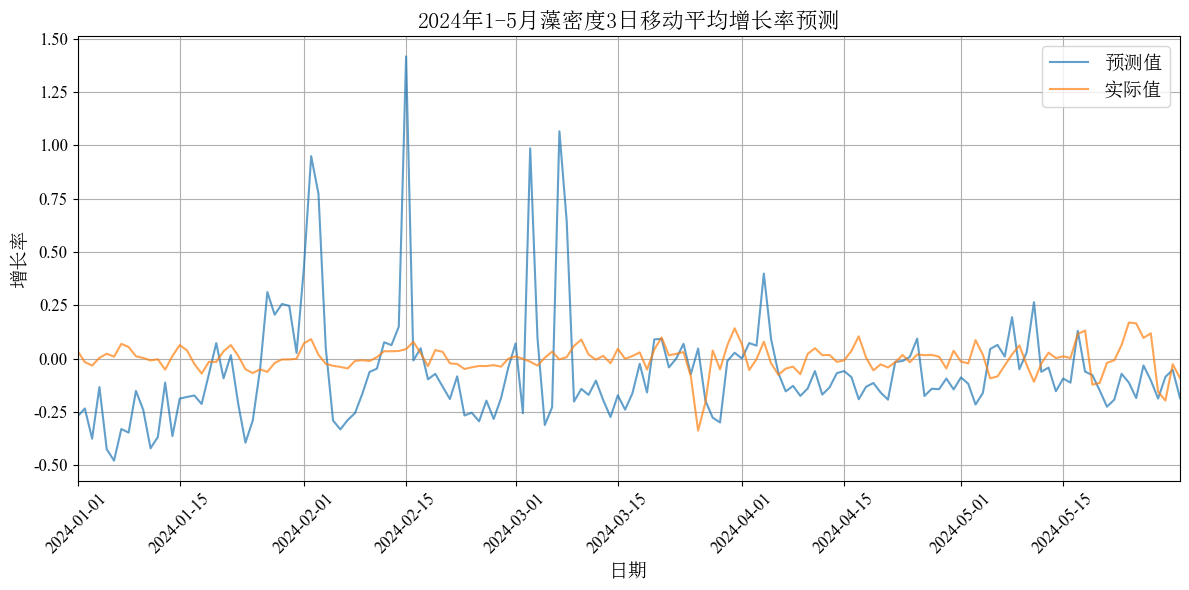

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import logging
from torch.optim.lr_scheduler import OneCycleLR

# 设置字体
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimSun', 'DejaVu Sans']
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['axes.unicode_minus'] = False

chinese_font = fm.FontProperties(fname='/root/Download/Modis-algae-aliyun/AlgaeBloomForecast-20241122/SIMSUN.TTC', size=14)
english_font = fm.FontProperties(fname='/root/Download/Modis-algae-aliyun/AlgaeBloomForecast-20241122/TIMES.TTF', size=14)

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
# 读取数据
df = pd.read_csv('20-merged_all_data.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# 明天相对于今天的增长率
df['density_growth'] = (df['density'] - df['density'].shift(1)) / df['density'].shift(1)
df['density_growth'] = df['density_growth'].interpolate(method='linear')

window_size = 2
df['density_growth_smoothed'] = df['density_growth'].rolling(window=window_size, center=True).mean()
df['density_growth_smoothed'] = df['density_growth_smoothed'].interpolate(method='linear')

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                           batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

def create_sequence_for_date(data, date_index, seq_length):
    """为指定日期创建输入序列"""
    if date_index < seq_length:
        return None
    return data[date_index - seq_length:date_index]

# 数据预处理
features = ['temperature', 'pH', 'oxygen', 'permanganate', 'TN', 'conductivity', 
                        'turbidity', 'chla', 'density', 'density_growth', 'GMT_0000_PAR', 'GMT_0300_PAR', 
                        'GMT_0900_PAR', 'GMT_2100_PAR', 'MPAR', 'APAR', 'PPDI', 'PAI',
                        'eutrophication_index', 'temp_ph_interaction', 'wind_north',
                        'weather_heavy_rain', 'weather_temp_index', 'temperature_high',
                        'strong_wind', 'density_growth_smoothed']
data = df[features].values
# 处理缺失值
data = np.nan_to_num(data, nan=0)

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# 首先检查数据集的基本信息
print("数据集总长度:", len(df))
print("所有日期范围:", df.index.min(), "到", df.index.max())

# 使用最后20%的数据作为测试集
train_size = int(len(df) * 0.8)
split_date = df.index[train_size]

print("训练集截止日期:", split_date)
print("split_date是否在数据范围内:", split_date in df.index)

# 重新划分数据
train_dates = df.index[:train_size]
test_dates = df.index[train_size:]
test_data = scaled_data[train_size:]

print("\n划分后:")
print("训练集大小:", len(train_dates))
print("测试集大小:", len(test_dates))
print("测试数据形状:", test_data.shape)

seq_length = 90

# 训练阶段
train_sequences = []
train_targets = []
for i in range(seq_length, train_size):
    seq = create_sequence_for_date(scaled_data, i, seq_length)
    if seq is not None:
        train_sequences.append(seq)
        train_targets.append(scaled_data[i, features.index('density_growth_smoothed')])

# 转换为PyTorch张量
X_train = torch.FloatTensor(train_sequences)
y_train = torch.FloatTensor(train_targets)

# 创建数据加载器
train_dataset = TensorDataset(X_train, y_train.unsqueeze(1))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 初始化模型
model = LSTMModel(input_size=len(features), hidden_size=64, 
                 num_layers=2, output_size=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 训练模型
epochs = 300
for epoch in range(epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    
    if (epoch + 1) % 5 == 0:  # 每5个epoch输出一次
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# 预测阶段
model.eval()
predictions = []
actual_values = []
prediction_dates = []

current_sequence = scaled_data[train_size-seq_length:train_size]

with torch.no_grad():
    for i in range(len(test_data)-1):  # 注意这里减1
        current_sequence_tensor = torch.FloatTensor(current_sequence).unsqueeze(0)
        pred = model(current_sequence_tensor)
        
        predictions.append(pred.item())
        actual_values.append(test_data[i+1, features.index('density_growth_smoothed')])  # 使用下一天的实际值
        
        # 更新序列使用当天的观测值
        current_sequence = np.vstack([
            current_sequence[1:],
            test_data[i]
        ])
        
        prediction_dates.append(test_dates[i])
        
        if i % 10 == 0:
            print(f"正在预测: {test_dates[i]}")

# 打印预测结果的长度
print(f"预测结果数量: {len(predictions)}")
print(f"实际值数量: {len(actual_values)}")

predictions_array = np.array(predictions).reshape(-1, 1)
actual_values_array = np.array(actual_values).reshape(-1, 1)

print(f"predictions_array shape: {predictions_array.shape}")
print(f"actual_values_array shape: {actual_values_array.shape}")

# 创建完整的特征数组
pred_full_features = np.zeros((len(predictions), len(features)))
actual_full_features = np.zeros((len(actual_values), len(features)))

print(f"pred_full_features shape: {pred_full_features.shape}")
print(f"actual_full_features shape: {actual_full_features.shape}")

# 将预测值和实际值放入对应的位置
density_growth_idx = features.index('density_growth_smoothed')
pred_full_features[:, density_growth_idx] = predictions_array.ravel()
actual_full_features[:, density_growth_idx] = actual_values_array.ravel()

# 反归一化
predictions = scaler.inverse_transform(pred_full_features)[:, density_growth_idx]
actual_values = scaler.inverse_transform(actual_full_features)[:, density_growth_idx]
# 绘制结果
plt.figure(figsize=(12, 6))

# 筛选2024年1-5月的数据
start_date = '2024-01-01'
end_date = '2024-05-31'
mask = (pd.to_datetime(prediction_dates) >= start_date) & (pd.to_datetime(prediction_dates) <= end_date)

# 绘制2024年1-5月的预测结果
plt.plot(pd.to_datetime(prediction_dates)[mask], predictions[mask], label='预测值', alpha=0.7)
plt.plot(pd.to_datetime(prediction_dates)[mask], actual_values[mask], label='实际值', alpha=0.7)

plt.title('2024年1-5月藻密度3日移动平均增长率预测', fontproperties=chinese_font, fontsize=16)
plt.xlabel('日期', fontproperties=chinese_font, fontsize=14)
plt.ylabel('增长率', fontproperties=chinese_font, fontsize=14)
plt.legend(prop=chinese_font)
plt.grid(True)

# 设置坐标轴刻度字体
ax = plt.gca()
plt.xticks(rotation=45)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(english_font)
plt.tick_params(axis='both', which='major', labelsize=12)

# 设置x轴时间范围
plt.xlim(pd.to_datetime(start_date), pd.to_datetime(end_date))

plt.tight_layout()
plt.show()


## 后天相对于今天的增长率

数据集总长度: 1308
所有日期范围: 2021-01-01 00:00:00 到 2024-07-31 00:00:00
训练集截止日期: 2023-11-13 00:00:00
split_date是否在数据范围内: True

划分后:
训练集大小: 1046
测试集大小: 262
测试数据形状: (262, 26)
Epoch [5/300], Loss: 0.0056
Epoch [10/300], Loss: 0.0025
Epoch [15/300], Loss: 0.0019
Epoch [20/300], Loss: 0.0014
Epoch [25/300], Loss: 0.0005
Epoch [30/300], Loss: 0.0009
Epoch [35/300], Loss: 0.0011
Epoch [40/300], Loss: 0.0046
Epoch [45/300], Loss: 0.0006
Epoch [50/300], Loss: 0.0018
Epoch [55/300], Loss: 0.0016
Epoch [60/300], Loss: 0.0009
Epoch [65/300], Loss: 0.0007
Epoch [70/300], Loss: 0.0012
Epoch [75/300], Loss: 0.0013
Epoch [80/300], Loss: 0.0009
Epoch [85/300], Loss: 0.0025
Epoch [90/300], Loss: 0.0004
Epoch [95/300], Loss: 0.0015
Epoch [100/300], Loss: 0.0005
Epoch [105/300], Loss: 0.0004
Epoch [110/300], Loss: 0.0006
Epoch [115/300], Loss: 0.0009
Epoch [120/300], Loss: 0.0010
Epoch [125/300], Loss: 0.0002
Epoch [130/300], Loss: 0.0004
Epoch [135/300], Loss: 0.0005
Epoch [140/300], Loss: 0.0003
Epoch [145/300],

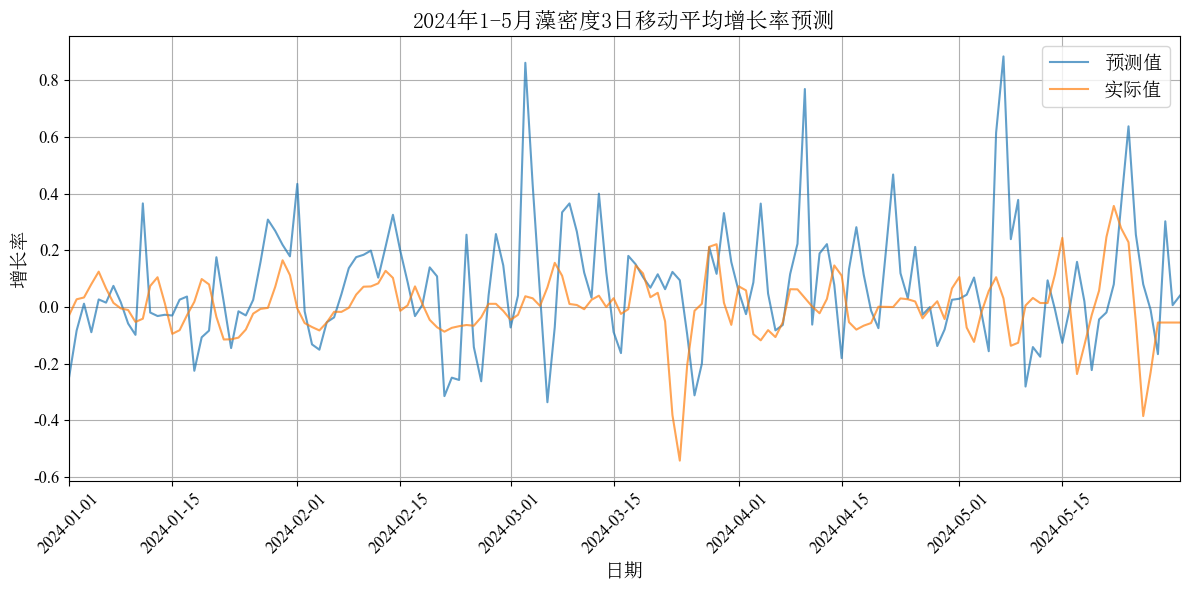

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import logging
from torch.optim.lr_scheduler import OneCycleLR

# 设置字体
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimSun', 'DejaVu Sans']
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['axes.unicode_minus'] = False

chinese_font = fm.FontProperties(fname='/root/Download/Modis-algae-aliyun/AlgaeBloomForecast-20241122/SIMSUN.TTC', size=14)
english_font = fm.FontProperties(fname='/root/Download/Modis-algae-aliyun/AlgaeBloomForecast-20241122/TIMES.TTF', size=14)

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
# 读取数据
df = pd.read_csv('20-merged_all_data.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# 计算后天相对于今天的增长率
df['density_growth'] = (df['density'].shift(-2) - df['density']) / df['density']
df['density_growth'] = df['density_growth'].interpolate(method='linear')
window_size = 2
df['density_growth_smoothed'] = df['density_growth'].rolling(window=window_size, center=True).mean()
df['density_growth_smoothed'] = df['density_growth_smoothed'].interpolate(method='linear')

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                           batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

def create_sequence_for_date(data, date_index, seq_length):
    """为指定日期创建输入序列"""
    if date_index < seq_length:
        return None
    return data[date_index - seq_length:date_index]

# 数据预处理
features = ['temperature', 'pH', 'oxygen', 'permanganate', 'TN', 'conductivity', 
                        'turbidity', 'chla', 'density', 'density_growth', 'GMT_0000_PAR', 'GMT_0300_PAR', 
                        'GMT_0900_PAR', 'GMT_2100_PAR', 'MPAR', 'APAR', 'PPDI', 'PAI',
                        'eutrophication_index', 'temp_ph_interaction', 'wind_north',
                        'weather_heavy_rain', 'weather_temp_index', 'temperature_high',
                        'strong_wind', 'density_growth_smoothed']
data = df[features].values
# 处理缺失值
data = np.nan_to_num(data, nan=0)

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# 首先检查数据集的基本信息
print("数据集总长度:", len(df))
print("所有日期范围:", df.index.min(), "到", df.index.max())

# 使用最后20%的数据作为测试集
train_size = int(len(df) * 0.8)
split_date = df.index[train_size]

print("训练集截止日期:", split_date)
print("split_date是否在数据范围内:", split_date in df.index)

# 重新划分数据
train_dates = df.index[:train_size]
test_dates = df.index[train_size:]
test_data = scaled_data[train_size:]

print("\n划分后:")
print("训练集大小:", len(train_dates))
print("测试集大小:", len(test_dates))
print("测试数据形状:", test_data.shape)

seq_length = 90

# 训练阶段
train_sequences = []
train_targets = []
for i in range(seq_length, train_size):
    seq = create_sequence_for_date(scaled_data, i, seq_length)
    if seq is not None:
        train_sequences.append(seq)
        train_targets.append(scaled_data[i, features.index('density_growth_smoothed')])

# 转换为PyTorch张量
X_train = torch.FloatTensor(train_sequences)
y_train = torch.FloatTensor(train_targets)

# 创建数据加载器
train_dataset = TensorDataset(X_train, y_train.unsqueeze(1))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 初始化模型
model = LSTMModel(input_size=len(features), hidden_size=64, 
                 num_layers=2, output_size=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 训练模型
epochs = 300
for epoch in range(epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    
    if (epoch + 1) % 5 == 0:  # 每5个epoch输出一次
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# 预测阶段
model.eval()
predictions = []
actual_values = []
prediction_dates = []

current_sequence = scaled_data[train_size-seq_length:train_size]

with torch.no_grad():
    for i in range(len(test_data)-2):  # 减2因为最后两天没有后天的实际值
        current_sequence_tensor = torch.FloatTensor(current_sequence).unsqueeze(0)
        pred = model(current_sequence_tensor)
        
        predictions.append(pred.item())
        actual_values.append(test_data[i+2, features.index('density_growth_smoothed')])  # 使用后天的实际值
        
        current_sequence = np.vstack([
            current_sequence[1:],
            test_data[i]
        ])
        
        prediction_dates.append(test_dates[i])
        
        if i % 10 == 0:
            print(f"正在预测: {test_dates[i]}")

# 打印预测结果的长度
print(f"预测结果数量: {len(predictions)}")
print(f"实际值数量: {len(actual_values)}")

predictions_array = np.array(predictions).reshape(-1, 1)
actual_values_array = np.array(actual_values).reshape(-1, 1)

print(f"predictions_array shape: {predictions_array.shape}")
print(f"actual_values_array shape: {actual_values_array.shape}")

# 创建完整的特征数组
pred_full_features = np.zeros((len(predictions), len(features)))
actual_full_features = np.zeros((len(actual_values), len(features)))

print(f"pred_full_features shape: {pred_full_features.shape}")
print(f"actual_full_features shape: {actual_full_features.shape}")

# 将预测值和实际值放入对应的位置
density_growth_idx = features.index('density_growth_smoothed')
pred_full_features[:, density_growth_idx] = predictions_array.ravel()
actual_full_features[:, density_growth_idx] = actual_values_array.ravel()

# 反归一化
predictions = scaler.inverse_transform(pred_full_features)[:, density_growth_idx]
actual_values = scaler.inverse_transform(actual_full_features)[:, density_growth_idx]
# 绘制结果
plt.figure(figsize=(12, 6))

# 筛选2024年1-5月的数据
start_date = '2024-01-01'
end_date = '2024-05-31'
mask = (pd.to_datetime(prediction_dates) >= start_date) & (pd.to_datetime(prediction_dates) <= end_date)

# 绘制2024年1-5月的预测结果
plt.plot(pd.to_datetime(prediction_dates)[mask], predictions[mask], label='预测值', alpha=0.7)
plt.plot(pd.to_datetime(prediction_dates)[mask], actual_values[mask], label='实际值', alpha=0.7)

plt.title('2024年1-5月藻密度3日移动平均增长率预测', fontproperties=chinese_font, fontsize=16)
plt.xlabel('日期', fontproperties=chinese_font, fontsize=14)
plt.ylabel('增长率', fontproperties=chinese_font, fontsize=14)
plt.legend(prop=chinese_font)
plt.grid(True)

# 设置坐标轴刻度字体
ax = plt.gca()
plt.xticks(rotation=45)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(english_font)
plt.tick_params(axis='both', which='major', labelsize=12)

# 设置x轴时间范围
plt.xlim(pd.to_datetime(start_date), pd.to_datetime(end_date))

plt.tight_layout()
plt.show()


数据集总长度: 1308
所有日期范围: 2021-01-01 00:00:00 到 2024-07-31 00:00:00
训练集截止日期: 2023-11-13 00:00:00
split_date是否在数据范围内: True

划分后:
训练集大小: 1046
测试集大小: 262
测试数据形状: (262, 26)
Epoch [5/300], Loss: 0.0065
Epoch [10/300], Loss: 0.0103
Epoch [15/300], Loss: 0.0006
Epoch [20/300], Loss: 0.0024
Epoch [25/300], Loss: 0.0008
Epoch [30/300], Loss: 0.0136
Epoch [35/300], Loss: 0.0007
Epoch [40/300], Loss: 0.0009
Epoch [45/300], Loss: 0.0016
Epoch [50/300], Loss: 0.0004
Epoch [55/300], Loss: 0.0007
Epoch [60/300], Loss: 0.0006
Epoch [65/300], Loss: 0.0010
Epoch [70/300], Loss: 0.0009
Epoch [75/300], Loss: 0.0009
Epoch [80/300], Loss: 0.0005
Epoch [85/300], Loss: 0.0022
Epoch [90/300], Loss: 0.0008
Epoch [95/300], Loss: 0.0006
Epoch [100/300], Loss: 0.0007
Epoch [105/300], Loss: 0.0005
Epoch [110/300], Loss: 0.0004
Epoch [115/300], Loss: 0.0008
Epoch [120/300], Loss: 0.0013
Epoch [125/300], Loss: 0.0006
Epoch [130/300], Loss: 0.0003
Epoch [135/300], Loss: 0.0013
Epoch [140/300], Loss: 0.0006
Epoch [145/300],

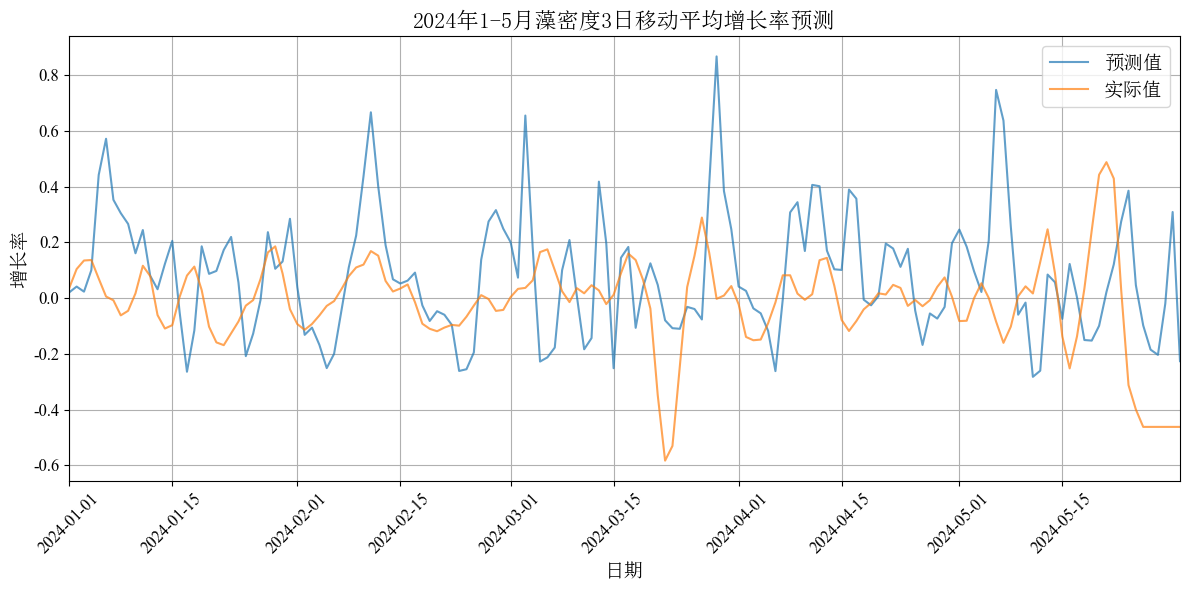

In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import logging
from torch.optim.lr_scheduler import OneCycleLR

# 设置字体
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimSun', 'DejaVu Sans']
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['axes.unicode_minus'] = False

chinese_font = fm.FontProperties(fname='/root/Download/Modis-algae-aliyun/AlgaeBloomForecast-20241122/SIMSUN.TTC', size=14)
english_font = fm.FontProperties(fname='/root/Download/Modis-algae-aliyun/AlgaeBloomForecast-20241122/TIMES.TTF', size=14)

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
# 读取数据
df = pd.read_csv('20-merged_all_data.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# 计算后天相对于今天的增长率
df['density_growth'] = (df['density'].shift(-3) - df['density']) / df['density']
df['density_growth'] = df['density_growth'].interpolate(method='linear')
window_size = 2
df['density_growth_smoothed'] = df['density_growth'].rolling(window=window_size, center=True).mean()
df['density_growth_smoothed'] = df['density_growth_smoothed'].interpolate(method='linear')

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                           batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

def create_sequence_for_date(data, date_index, seq_length):
    """为指定日期创建输入序列"""
    if date_index < seq_length:
        return None
    return data[date_index - seq_length:date_index]

# 数据预处理
features = ['temperature', 'pH', 'oxygen', 'permanganate', 'TN', 'conductivity', 
                        'turbidity', 'chla', 'density', 'density_growth', 'GMT_0000_PAR', 'GMT_0300_PAR', 
                        'GMT_0900_PAR', 'GMT_2100_PAR', 'MPAR', 'APAR', 'PPDI', 'PAI',
                        'eutrophication_index', 'temp_ph_interaction', 'wind_north',
                        'weather_heavy_rain', 'weather_temp_index', 'temperature_high',
                        'strong_wind', 'density_growth_smoothed']
data = df[features].values
# 处理缺失值
data = np.nan_to_num(data, nan=0)

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# 首先检查数据集的基本信息
print("数据集总长度:", len(df))
print("所有日期范围:", df.index.min(), "到", df.index.max())

# 使用最后20%的数据作为测试集
train_size = int(len(df) * 0.8)
split_date = df.index[train_size]

print("训练集截止日期:", split_date)
print("split_date是否在数据范围内:", split_date in df.index)

# 重新划分数据
train_dates = df.index[:train_size]
test_dates = df.index[train_size:]
test_data = scaled_data[train_size:]

print("\n划分后:")
print("训练集大小:", len(train_dates))
print("测试集大小:", len(test_dates))
print("测试数据形状:", test_data.shape)

seq_length = 90

# 训练阶段
train_sequences = []
train_targets = []
for i in range(seq_length, train_size):
    seq = create_sequence_for_date(scaled_data, i, seq_length)
    if seq is not None:
        train_sequences.append(seq)
        train_targets.append(scaled_data[i, features.index('density_growth_smoothed')])

# 转换为PyTorch张量
X_train = torch.FloatTensor(train_sequences)
y_train = torch.FloatTensor(train_targets)

# 创建数据加载器
train_dataset = TensorDataset(X_train, y_train.unsqueeze(1))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 初始化模型
model = LSTMModel(input_size=len(features), hidden_size=64, 
                 num_layers=2, output_size=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 训练模型
epochs = 300
for epoch in range(epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    
    if (epoch + 1) % 5 == 0:  # 每5个epoch输出一次
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# 预测阶段
model.eval()
predictions = []
actual_values = []
prediction_dates = []

current_sequence = scaled_data[train_size-seq_length:train_size]

with torch.no_grad():
    for i in range(len(test_data)-3):  # 减2因为最后两天没有后天的实际值
        current_sequence_tensor = torch.FloatTensor(current_sequence).unsqueeze(0)
        pred = model(current_sequence_tensor)
        
        predictions.append(pred.item())
        actual_values.append(test_data[i+3, features.index('density_growth_smoothed')])  # 使用后天的实际值
        
        current_sequence = np.vstack([
            current_sequence[1:],
            test_data[i]
        ])
        
        prediction_dates.append(test_dates[i])
        
        if i % 10 == 0:
            print(f"正在预测: {test_dates[i]}")

# 打印预测结果的长度
print(f"预测结果数量: {len(predictions)}")
print(f"实际值数量: {len(actual_values)}")

predictions_array = np.array(predictions).reshape(-1, 1)
actual_values_array = np.array(actual_values).reshape(-1, 1)

print(f"predictions_array shape: {predictions_array.shape}")
print(f"actual_values_array shape: {actual_values_array.shape}")

# 创建完整的特征数组
pred_full_features = np.zeros((len(predictions), len(features)))
actual_full_features = np.zeros((len(actual_values), len(features)))

print(f"pred_full_features shape: {pred_full_features.shape}")
print(f"actual_full_features shape: {actual_full_features.shape}")

# 将预测值和实际值放入对应的位置
density_growth_idx = features.index('density_growth_smoothed')
pred_full_features[:, density_growth_idx] = predictions_array.ravel()
actual_full_features[:, density_growth_idx] = actual_values_array.ravel()

# 反归一化
predictions = scaler.inverse_transform(pred_full_features)[:, density_growth_idx]
actual_values = scaler.inverse_transform(actual_full_features)[:, density_growth_idx]
# 绘制结果
plt.figure(figsize=(12, 6))

# 筛选2024年1-5月的数据
start_date = '2024-01-01'
end_date = '2024-05-31'
mask = (pd.to_datetime(prediction_dates) >= start_date) & (pd.to_datetime(prediction_dates) <= end_date)

# 绘制2024年1-5月的预测结果
plt.plot(pd.to_datetime(prediction_dates)[mask], predictions[mask], label='预测值', alpha=0.7)
plt.plot(pd.to_datetime(prediction_dates)[mask], actual_values[mask], label='实际值', alpha=0.7)

plt.title('2024年1-5月藻密度3日移动平均增长率预测', fontproperties=chinese_font, fontsize=16)
plt.xlabel('日期', fontproperties=chinese_font, fontsize=14)
plt.ylabel('增长率', fontproperties=chinese_font, fontsize=14)
plt.legend(prop=chinese_font)
plt.grid(True)

# 设置坐标轴刻度字体
ax = plt.gca()
plt.xticks(rotation=45)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(english_font)
plt.tick_params(axis='both', which='major', labelsize=12)

# 设置x轴时间范围
plt.xlim(pd.to_datetime(start_date), pd.to_datetime(end_date))

plt.tight_layout()
plt.show()
